In [1]:
import geopandas as gpd
import altair as alt
import pandas as pd

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import DistanceMetric

In [2]:
# precint_footprint = gpd.read_file('..//data//Police Precincts.geojson')

trees = gpd.read_file('2015 Street Tree Census - Tree Data.geojson')

In [3]:
# Preprocess data
trees = trees.to_crs(epsg=4326) # Convert to longitude-latitude coordinate system

In [4]:
trees['longitude'] = trees['longitude'].astype(float)
trees['latitude'] = trees['latitude'].astype(float)

In [5]:
import pickle

with open('data.pickle', 'rb') as f:
    data = pickle.load(f, encoding='binary')

data.head(5)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,OCC,OCC_END
0,506547392,03/29/2018,20:30:00,<NA>,NaN,32.0,2018-03-30,351,CRIMINAL MISCHIEF & RELATED OF,254.0,...,40.810877,-73.941064,"(40.810877241, -73.941064151)",PATROL BORO MAN NORTH,NaN,25-44,WHITE,F,2018-03-29,<NA>
1,629632833,02/06/2018,23:15:00,<NA>,NaN,52.0,2018-02-07,341,PETIT LARCENY,333.0,...,40.873671,-73.908014,"(40.873671035, -73.908013649)",PATROL BORO BRONX,NaN,NaN,UNKNOWN,D,2018-02-06,<NA>
2,787203902,11/21/2018,00:15:00,11/21/2018,00:20:00,75.0,2018-11-21,341,PETIT LARCENY,321.0,...,40.651782,-73.885457,"(40.651782232, -73.885456761)",PATROL BORO BKLYN NORTH,NaN,NaN,UNKNOWN,D,2018-11-21,11/21/2018
3,280364018,06/09/2018,21:42:00,06/09/2018,21:43:00,10.0,2018-06-10,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,40.759310,-73.994706,"(40.759310399, -73.994706072)",PATROL BORO MAN SOUTH,NaN,18-24,WHITE HISPANIC,F,2018-06-09,06/09/2018
4,985800320,11/10/2018,19:40:00,11/10/2018,19:45:00,19.0,2018-11-10,341,PETIT LARCENY,333.0,...,40.764536,-73.970728,"(40.764535539, -73.970728388)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,D,2018-11-10,11/10/2018


In [6]:
data

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,OCC,OCC_END
0,506547392,03/29/2018,20:30:00,<NA>,NaN,32.0,2018-03-30,351,CRIMINAL MISCHIEF & RELATED OF,254.0,...,40.810877,-73.941064,"(40.810877241, -73.941064151)",PATROL BORO MAN NORTH,NaN,25-44,WHITE,F,2018-03-29,<NA>
1,629632833,02/06/2018,23:15:00,<NA>,NaN,52.0,2018-02-07,341,PETIT LARCENY,333.0,...,40.873671,-73.908014,"(40.873671035, -73.908013649)",PATROL BORO BRONX,NaN,NaN,UNKNOWN,D,2018-02-06,<NA>
2,787203902,11/21/2018,00:15:00,11/21/2018,00:20:00,75.0,2018-11-21,341,PETIT LARCENY,321.0,...,40.651782,-73.885457,"(40.651782232, -73.885456761)",PATROL BORO BKLYN NORTH,NaN,NaN,UNKNOWN,D,2018-11-21,11/21/2018
3,280364018,06/09/2018,21:42:00,06/09/2018,21:43:00,10.0,2018-06-10,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,40.759310,-73.994706,"(40.759310399, -73.994706072)",PATROL BORO MAN SOUTH,NaN,18-24,WHITE HISPANIC,F,2018-06-09,06/09/2018
4,985800320,11/10/2018,19:40:00,11/10/2018,19:45:00,19.0,2018-11-10,341,PETIT LARCENY,333.0,...,40.764536,-73.970728,"(40.764535539, -73.970728388)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,D,2018-11-10,11/10/2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825494,104527061,05/01/2008,18:55:00,05/01/2018,19:00:00,10.0,2018-05-01,235,DANGEROUS DRUGS,511.0,...,40.756788,-73.996540,"(40.756788048, -73.996539912)",PATROL BORO MAN SOUTH,NaN,NaN,UNKNOWN,E,2008-05-01,05/01/2018
7825495,284201488,05/18/2018,14:50:00,05/18/2018,14:55:00,122.0,2018-05-22,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,40.577953,-74.102317,"(40.577953265, -74.102316756)",PATROL BORO STATEN ISLAND,NaN,<18,WHITE HISPANIC,M,2018-05-18,05/18/2018
7825496,808565901,11/19/2018,02:25:00,11/19/2018,02:30:00,110.0,2018-11-19,109,GRAND LARCENY,421.0,...,40.743188,-73.862427,"(40.743188053, -73.862427079)",PATROL BORO QUEENS NORTH,NaN,25-44,ASIAN / PACIFIC ISLANDER,M,2018-11-19,11/19/2018
7825497,649441648,02/03/2018,10:02:00,02/03/2018,12:15:00,122.0,2018-02-03,578,HARRASSMENT 2,638.0,...,40.593665,-74.089000,"(40.593664627, -74.089000194)",PATROL BORO STATEN ISLAND,NaN,45-64,WHITE,M,2018-02-03,02/03/2018


In [7]:
data['Longitude'].dropna()

0         -73.941064
1         -73.908014
2         -73.885457
3         -73.994706
4         -73.970728
             ...    
7825494   -73.996540
7825495   -74.102317
7825496   -73.862427
7825497   -74.089000
7825498   -73.944529
Name: Longitude, Length: 7781995, dtype: float64

In [8]:
data['Latitude'].dropna()

0          40.810877
1          40.873671
2          40.651782
3          40.759310
4          40.764536
             ...    
7825494    40.756788
7825495    40.577953
7825496    40.743188
7825497    40.593665
7825498    40.688872
Name: Latitude, Length: 7781995, dtype: float64

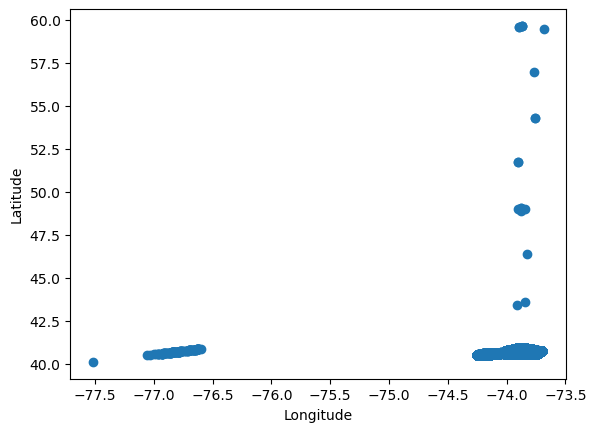

In [9]:
longitude = data['Longitude']
latitude = data['Latitude']

# Plot Longitude and Latitude on a scatter plot
plt.scatter(longitude, latitude)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [10]:
data = data.loc[(data['Longitude'] >= -74.5) & (data['Latitude'] <= 42.5)]

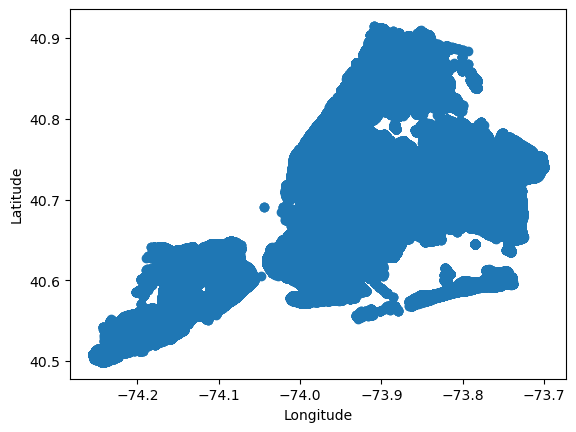

In [11]:
longitude = data['Longitude']
latitude = data['Latitude']

# Plot Longitude and Latitude on a scatter plot
plt.scatter(longitude, latitude)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [12]:
from sklearn.neighbors import KDTree
import numpy as np

def distance(loc1, loc2):
    loc1 = np.asarray(loc1)
    loc2 = np.asarray(loc2)
    return np.sqrt(np.sum((loc1 - loc2)**2))

# Create an array of centroid locations
centroids_array = trees[['latitude', 'longitude']].values

# Build a kd-tree using the centroid locations
tree = KDTree(centroids_array)

# Iterate through rows of the data frame
for index, row in data.iterrows():
    crime_loc = [row['Latitude'], row['Longitude']]
    # Use the kd-tree to find the index of the nearest centroid
    _, nearest_centroid_index = tree.query([crime_loc], k=1)
    # Get the location of the nearest centroid
    nearest_centroid_loc = centroids_array[nearest_centroid_index][0]
    # Calculate the distance between the crime location and the nearest centroid
    dist = distance(crime_loc, nearest_centroid_loc)
    data.at[index, 'Distance'] = dist

C:\Users\Kelvi\AppData\Local\Temp\ipykernel_14276\3134998564.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.at[index, 'Distance'] = dist


In [13]:
data

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,OCC,OCC_END,Distance
0,506547392,03/29/2018,20:30:00,<NA>,NaN,32.0,2018-03-30,351,CRIMINAL MISCHIEF & RELATED OF,254.0,...,-73.941064,"(40.810877241, -73.941064151)",PATROL BORO MAN NORTH,NaN,25-44,WHITE,F,2018-03-29,<NA>,0.000123
1,629632833,02/06/2018,23:15:00,<NA>,NaN,52.0,2018-02-07,341,PETIT LARCENY,333.0,...,-73.908014,"(40.873671035, -73.908013649)",PATROL BORO BRONX,NaN,NaN,UNKNOWN,D,2018-02-06,<NA>,0.000093
2,787203902,11/21/2018,00:15:00,11/21/2018,00:20:00,75.0,2018-11-21,341,PETIT LARCENY,321.0,...,-73.885457,"(40.651782232, -73.885456761)",PATROL BORO BKLYN NORTH,NaN,NaN,UNKNOWN,D,2018-11-21,11/21/2018,0.000091
3,280364018,06/09/2018,21:42:00,06/09/2018,21:43:00,10.0,2018-06-10,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,-73.994706,"(40.759310399, -73.994706072)",PATROL BORO MAN SOUTH,NaN,18-24,WHITE HISPANIC,F,2018-06-09,06/09/2018,0.000087
4,985800320,11/10/2018,19:40:00,11/10/2018,19:45:00,19.0,2018-11-10,341,PETIT LARCENY,333.0,...,-73.970728,"(40.764535539, -73.970728388)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,D,2018-11-10,11/10/2018,0.000381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825494,104527061,05/01/2008,18:55:00,05/01/2018,19:00:00,10.0,2018-05-01,235,DANGEROUS DRUGS,511.0,...,-73.996540,"(40.756788048, -73.996539912)",PATROL BORO MAN SOUTH,NaN,NaN,UNKNOWN,E,2008-05-01,05/01/2018,0.000159
7825495,284201488,05/18/2018,14:50:00,05/18/2018,14:55:00,122.0,2018-05-22,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,-74.102317,"(40.577953265, -74.102316756)",PATROL BORO STATEN ISLAND,NaN,<18,WHITE HISPANIC,M,2018-05-18,05/18/2018,0.000473
7825496,808565901,11/19/2018,02:25:00,11/19/2018,02:30:00,110.0,2018-11-19,109,GRAND LARCENY,421.0,...,-73.862427,"(40.743188053, -73.862427079)",PATROL BORO QUEENS NORTH,NaN,25-44,ASIAN / PACIFIC ISLANDER,M,2018-11-19,11/19/2018,0.000145
7825497,649441648,02/03/2018,10:02:00,02/03/2018,12:15:00,122.0,2018-02-03,578,HARRASSMENT 2,638.0,...,-74.089000,"(40.593664627, -74.089000194)",PATROL BORO STATEN ISLAND,NaN,45-64,WHITE,M,2018-02-03,02/03/2018,0.000079


In [14]:
data.sort_values(by=['Distance'])

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,OCC,OCC_END,Distance
2399212,849123088,05/16/2020,12:30:00,05/16/2020,12:51:00,109.0,2020-05-16,341,PETIT LARCENY,321.0,...,-73.792899,"(40.774755715000026, -73.79289929399994)",PATROL BORO QUEENS NORTH,NaN,45-64,WHITE,M,2020-05-16,05/16/2020,0.000002
4597786,729998841,10/31/2009,20:00:00,11/02/2009,06:00:00,109.0,2009-11-02,351,CRIMINAL MISCHIEF & RELATED OF,254.0,...,-73.792899,"(40.774755715, -73.792899294)",PATROL BORO QUEENS NORTH,NaN,45-64,WHITE,M,2009-10-31,11/02/2009,0.000002
7355455,454953542,06/28/2011,14:30:00,06/28/2011,14:45:00,109.0,2011-06-28,105,ROBBERY,366.0,...,-73.792899,"(40.774755715, -73.792899294)",PATROL BORO QUEENS NORTH,NaN,<18,WHITE,M,2011-06-28,06/28/2011,0.000002
3502297,102114352,07/07/2017,15:00:00,07/07/2017,15:05:00,109.0,2017-07-07,578,HARRASSMENT 2,638.0,...,-73.792899,"(40.774755715, -73.792899294)",PATROL BORO QUEENS NORTH,NaN,25-44,WHITE,F,2017-07-07,07/07/2017,0.000002
7232513,238381656,11/12/2008,20:40:00,11/12/2008,20:50:00,105.0,2008-11-12,236,DANGEROUS WEAPONS,782.0,...,-73.743870,"(40.695407549, -73.74387042)",PATROL BORO QUEENS SOUTH,NaN,NaN,UNKNOWN,E,2008-11-12,11/12/2008,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422938,438624546,10/24/2010,11:00:00,10/27/2010,14:30:00,100.0,2010-10-27,109,GRAND LARCENY,419.0,...,-73.930041,"(40.554863507, -73.930040686)",PATROL BORO QUEENS SOUTH,NaN,45-64,UNKNOWN,M,2010-10-24,10/27/2010,0.024045
3713828,572316561,11/20/2015,07:00:00,11/21/2015,15:00:00,100.0,2015-11-23,109,GRAND LARCENY,424.0,...,-73.930041,"(40.554863507, -73.930040686)",PATROL BORO QUEENS SOUTH,NaN,65+,WHITE,M,2015-11-20,11/21/2015,0.024045
1968245,740830432,05/02/2017,20:48:00,05/02/2017,21:00:00,1.0,2017-05-02,361,OFF. AGNST PUB ORD SENSBLTY &,649.0,...,-74.044528,"(40.690474361, -74.044527563)",PATROL BORO MAN SOUTH,NaN,NaN,UNKNOWN,E,2017-05-02,05/02/2017,0.028863
7243377,438342957,08/04/2013,14:00:00,08/04/2013,14:20:00,1.0,2013-08-04,341,PETIT LARCENY,339.0,...,-74.044528,"(40.690474361, -74.044527563)",PATROL BORO MAN SOUTH,NaN,45-64,WHITE,M,2013-08-04,08/04/2013,0.028863


In [15]:
import pickle

with open('distance3.pickle', 'wb') as f:
    pickle.dump(data, f)
